# 1. Install Dependencies and Setup

In [62]:
%pip install tensorflow tensorflow-gpu opencv-python matplotlib

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for tensorflow-gpu
Failed to build tensorflow-gpu
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [18 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "C:\Users\ADEBOSS\AppData\Local\Temp\pip-install-8pij5b1p\tensorflow-gpu_36e14e699ea24262a7dd4e98423e1a9e\setup.py", line 37, in <module>
          raise Exception(TF_REMOVAL_WARNING)
      Exception:
      
      The "tensorflow-gpu" package has been removed!
      
      Please install "tensorflow" instead.
      
      Other than the name, the two packages have been identical
      since TensorFlow 2.1, or roughly since Sep 2019. For more
      information, see: pypi.org/project/tensorflow-gpu
      
      
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
ERROR: Could not bu

In [63]:
%pip list

Package                      Version
---------------------------- -----------
absl-py                      1.4.0
asttokens                    2.2.1
astunparse                   1.6.3
autopep8                     2.0.0
backcall                     0.2.0
beautifulsoup4               4.11.1
blinker                      1.6.2
bs4                          0.0.1
cachetools                   5.3.0
certifi                      2022.12.7
charset-normalizer           3.0.1
click                        8.1.3
colorama                     0.4.6
comm                         0.1.3
confusion-matrix             0.1
contourpy                    1.0.7
cycler                       0.11.0
dabl                         0.2.5
debugpy                      1.6.7
decorator                    5.1.1
dill                         0.3.6
dm-tree                      0.1.8
etils                        1.0.0
executing                    1.2.0
filelock                     3.12.0
Flask                        2.3.2
flatbuf

In [64]:
import tensorflow as tf
import os

In [65]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [66]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [67]:
import cv2
import imghdr

In [106]:
data_dir = 'data/train' 

In [107]:
image_exts = ['jpeg','jpg', 'bmp', 'png', 'svg']

In [108]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [109]:
import numpy as np
from matplotlib import pyplot as plt

In [110]:
data = tf.keras.utils.image_dataset_from_directory('data/train')

Found 2637 files belonging to 2 classes.


In [111]:
data_iterator = data.as_numpy_iterator()

In [112]:
batch = data_iterator.next()

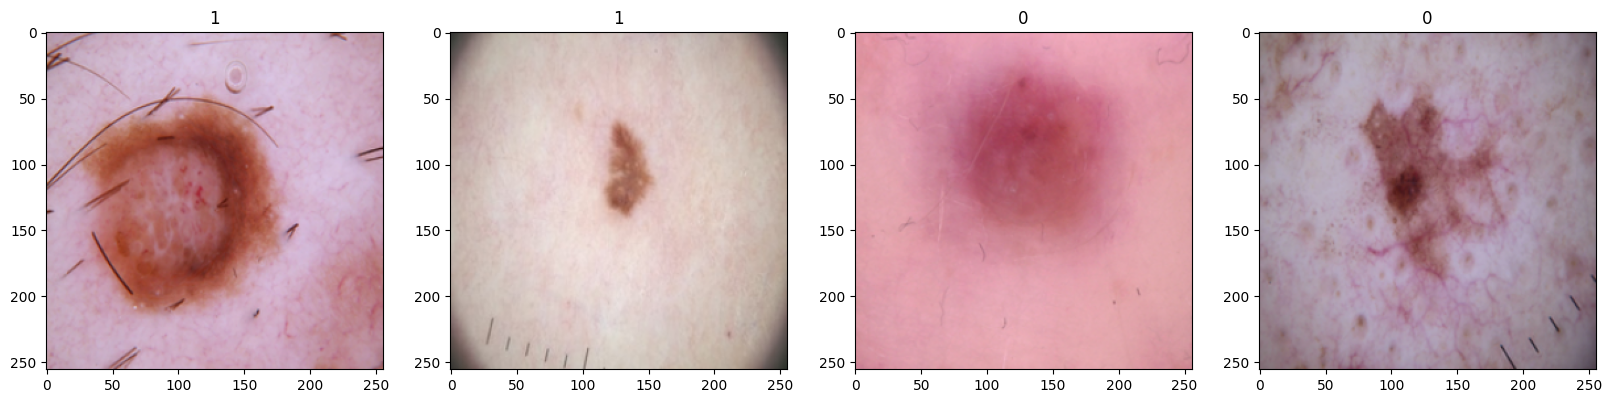

In [113]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [114]:
data = data.map(lambda x,y: (x/255, y))

In [115]:
data.as_numpy_iterator().next()

(array([[[[0.627451  , 0.6156863 , 0.5803922 ],
          [0.6242647 , 0.6125    , 0.5772059 ],
          [0.62352943, 0.6117647 , 0.5764706 ],
          ...,
          [0.66544116, 0.61446077, 0.59093136],
          [0.6627451 , 0.6117647 , 0.5882353 ],
          [0.6627451 , 0.6117647 , 0.5882353 ]],
 
         [[0.6338235 , 0.6220588 , 0.5867647 ],
          [0.6306372 , 0.6188725 , 0.5835784 ],
          [0.62990195, 0.61813724, 0.5828431 ],
          ...,
          [0.6632506 , 0.61665136, 0.59312195],
          [0.6615502 , 0.6117647 , 0.5882353 ],
          [0.65637255, 0.6117647 , 0.5882353 ]],
 
         [[0.6406863 , 0.62892157, 0.59362745],
          [0.6396906 , 0.6279259 , 0.59263176],
          [0.6413143 , 0.6295496 , 0.5942555 ],
          ...,
          [0.660049  , 0.61985296, 0.59446996],
          [0.65857846, 0.61446077, 0.59042585],
          [0.6522059 , 0.61446077, 0.5882353 ]],
 
         ...,
 
         [[0.6696078 , 0.6615196 , 0.625     ],
          [0.67598

# 5. Split Data

In [116]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [117]:
train_size

58

In [118]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [119]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [120]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [121]:
model = Sequential()

In [122]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [123]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [124]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 30, 30, 16)      

# 7. Train

In [125]:
logdir='logs'

In [126]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [127]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
58/58 [==============================] - 291s 5s/step - loss: 0.5531 - accuracy: 0.7080 - val_loss: 0.5199 - val_accuracy: 0.7812
Epoch 2/20
58/58 [==============================] - 236s 4s/step - loss: 0.4659 - accuracy: 0.7759 - val_loss: 0.4204 - val_accuracy: 0.7969
Epoch 3/20
58/58 [==============================] - 310s 5s/step - loss: 0.4271 - accuracy: 0.7856 - val_loss: 0.3985 - val_accuracy: 0.8047
Epoch 4/20
58/58 [==============================] - 298s 5s/step - loss: 0.3911 - accuracy: 0.7974 - val_loss: 0.4315 - val_accuracy: 0.8105
Epoch 5/20
58/58 [==============================] - 308s 5s/step - loss: 0.3922 - accuracy: 0.8055 - val_loss: 0.3722 - val_accuracy: 0.8320
Epoch 6/20
58/58 [==============================] - 312s 5s/step - loss: 0.3600 - accuracy: 0.8184 - val_loss: 0.3867 - val_accuracy: 0.8184
Epoch 7/20
58/58 [==============================] - 293s 5s/step - loss: 0.3334 - accuracy: 0.8276 - val_loss: 0.4498 - val_accuracy: 0.8008
Epoch 8/20
58

# 8. Plot Performance

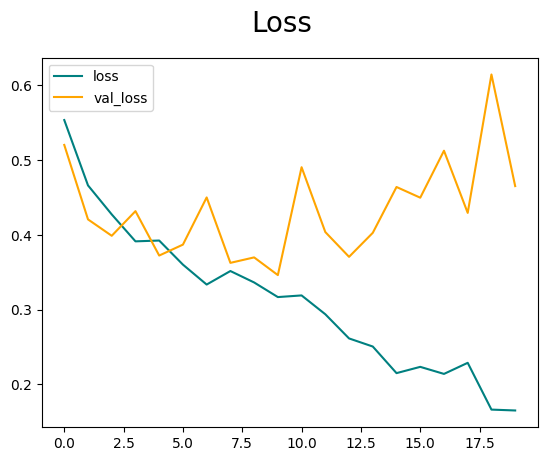

In [128]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

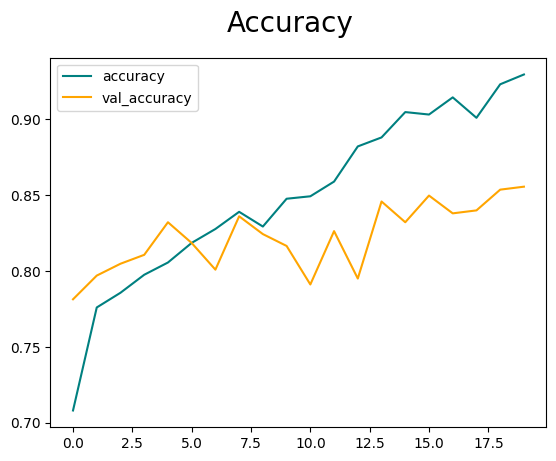

In [129]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [130]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [131]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [132]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 1s 1s/step


In [133]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.8942308, shape=(), dtype=float32) tf.Tensor(0.7815126, shape=(), dtype=float32) tf.Tensor(0.85546875, shape=(), dtype=float32)


# 10. Test

In [134]:
import cv2

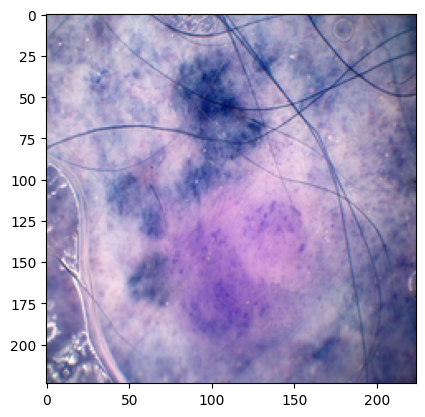

In [171]:
img = cv2.imread('data/test/malignant/1005.jpg')
plt.imshow(img)
plt.show()

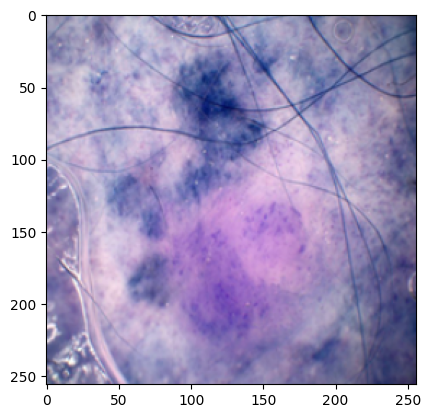

In [172]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [173]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 2s 2s/step


In [174]:
yhat

array([[0.6828985]], dtype=float32)

In [175]:
print(yhat)

[[0.6828985]]


In [176]:
if yhat < 0.5: 
    print(f'Predicted class is benign')
elif 0.5 < yhat < 1:
    print(f'Predicted class is malignant')
else:
    print(f'no referrence ')

Predicted class is benign


# 11. Save the Model

In [167]:
from tensorflow.keras.models import load_model

In [168]:
model.save(os.path.join('models','imageclassifier.h5'))

In [169]:
new_model = load_model('models/imageclassifier.h5')

In [170]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 24s 24s/step


array([[1.]], dtype=float32)